In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd


In [2]:
import sklearn
from sklearn.linear_model import LinearRegression
#rom sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LassoLars

from sklearn.linear_model import TweedieRegressor

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
sns.set(style="whitegrid")


In [12]:
df=pd.read_csv("~/git/xprize_covid/data/adjusted_data.csv",sep=",")


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
df.keys()

Index(['Unnamed: 0', 'CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'M1_Wildcard', 'ConfirmedCases',
       'ConfirmedDeaths', 'StringencyIndex', 'StringencyIndexForDisplay',
       'StringencyLegacyIndex', 'StringencyLegacyIndexForDisplay',
       'GovernmentRespons

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [26]:
df[(df.CountryName=="Sweden" )][["cumulative_smoothed_cases","ConfirmedCases"]]

,cumulative_smoothed_cases,ConfirmedCases
62345,0.000000,0.0
62346,0.000000,0.0
62347,0.000000,0.0
62348,0.000000,0.0
62349,0.000000,0.0
...,...,...
62677,227896.714286,243129.0
62678,232873.000000,243129.0
62679,237849.285714,243129.0
62680,242877.571429,260758.0


In [66]:
df.RegionName.replace("0","",inplace=True)
df.RegionCode.replace("0","",inplace=True)
#df[df.CountryName=="Aruba"][["RegionName","RegionCode"]]

In [67]:
df["country"]=df.CountryName+df.RegionName
casecolumns=["smoothed_deaths","smoothed_cases"]
tiny=1.e-20
countries=df["country"].unique()
countries

array(['Aruba', 'Afghanistan', 'Angola', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'BrazilAcre', 'BrazilAlagoas', 'BrazilAmazonas',
       'BrazilAmapa', 'BrazilBahia', 'BrazilCeara',
       'BrazilDistrito Federal', 'BrazilEspirito Santo', 'BrazilGoias',
       'BrazilMaranhao', 'BrazilMinas Gerais', 'BrazilMato Grosso do Sul',
       'BrazilMato Grosso', 'BrazilPara', 'BrazilParaiba',
       'BrazilPernambuco', 'BrazilPiaui', 'BrazilParana',
       'BrazilRio de Janeiro', 'BrazilRio Grande do Norte',
       'BrazilRondonia', 'BrazilRoraima', 'BrazilRio Grande do Sul',
       'BrazilSanta Catarina', 'BrazilSergipe', 'BrazilSao Paulo',
       'BrazilTocantins', 'Brazil', 'Barbados', 'Brunei', 'Bhutan',
       'Botswana', 'Central Africa

In [104]:
interventions=['C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag'] # , 'M1_Wildcard']

interventions=['C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls']

df["AnyIntervention"]=df[interventions].sum(axis=1)
df["AnyIntervention"]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
89300    21.0
89301    21.0
89302    21.0
89303     0.0
89304     0.0
Name: AnyIntervention, Length: 89305, dtype: float64

In [105]:
merged_df = pd.DataFrame([])
for country in countries:
    #print (country)
    temp_df=df.loc[df.country==country].reset_index()
    for key in casecolumns:
        #print (key)
        temp_df[key+"_diff7"]=temp_df[key].diff(7)
        temp_df[key+"_diff30"]=temp_df[key].diff(30)
        temp_df[key+"_ratio7"]=(tiny+temp_df[key+"_diff7"])/(temp_df[key]+tiny)
        temp_df[key+"_slope7"]=temp_df[key+"_diff7"]/(temp_df[key].max())
        temp_df[key+"_ratio30"]=(tiny+temp_df[key+"_diff7"])/(temp_df[key]+tiny)
        temp_df[key+"_slope30"]=temp_df[key+"_diff7"]/(temp_df[key].max())
        temp_df[key+"_diff-7"]=temp_df[key].diff(periods=-7)
        temp_df[key+"_diff-30"]=temp_df[key].diff(periods=-30)
        temp_df[key+"_ratio-7"]=(tiny+temp_df[key+"_diff-7"])/(temp_df[key]+tiny)
        temp_df[key+"_slope-7"]=temp_df[key+"_diff-7"]/(temp_df[key].max())
        temp_df[key+"_ratio-30"]=(tiny+temp_df[key+"_diff-7"])/(temp_df[key]+tiny)
        temp_df[key+"_slope-30"]=temp_df[key+"_diff-7"]/(temp_df[key].max())
        # Fix first 7 values
        temp_df[key+"_diff7"].fillna(0)
        temp_df[key+"_ratio7"].fillna(1)
        temp_df[key+"_slope7"].fillna(0)
        temp_df[key+"_diff30"].fillna(0)
        temp_df[key+"_ratio30"].fillna(1)
        temp_df[key+"_slope30"].fillna(0)
        temp_df[key+"_diff-7"].fillna(0)
        temp_df[key+"_ratio-7"].fillna(1)
        temp_df[key+"_slope-7"].fillna(0)
        temp_df[key+"_diff-30"].fillna(0)
        temp_df[key+"_ratio-30"].fillna(1)
        temp_df[key+"_slope-30"].fillna(0)
    for key in interventions+["AnyIntervention"]:
        temp_df[key+"_diff1"]=temp_df[key].diff(1)
        temp_df[key+"_diff-1"]=temp_df[key].diff(-1)
    merged_df=pd.concat([merged_df, temp_df], ignore_index=True,sort=False)


In [106]:
merged_df[merged_df.country=="Sweden"][["Date","smoothed_deaths_diff7","smoothed_deaths_diff-7","AnyIntervention_diff1"]].dropna()


,Date,smoothed_deaths_diff7,smoothed_deaths_diff-7,AnyIntervention_diff1
62352,2020-01-08,0.000000,0.000000,0.0
62353,2020-01-09,0.000000,0.000000,0.0
62354,2020-01-10,0.000000,0.000000,0.0
62355,2020-01-11,0.000000,0.000000,0.0
62356,2020-01-12,0.000000,0.000000,0.0
...,...,...,...,...
62670,2020-11-21,14.285714,-4.714286,0.0
62671,2020-11-22,14.285714,-4.714286,0.0
62672,2020-11-23,14.285714,-4.714286,0.0
62673,2020-11-24,15.285714,-3.285714,1.0


<ipython-input-115-ff800c394e12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["change"]=temp_df.smoothed_cases_slope7-temp_df["smoothed_cases_slope-7"]


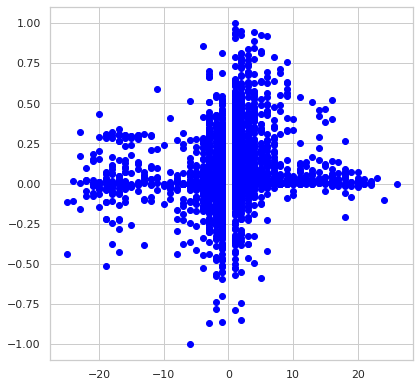

In [115]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
temp_df=merged_df.loc[merged_df.AnyIntervention_diff1 != 0]
temp_df["change"]=temp_df.smoothed_cases_slope7-temp_df["smoothed_cases_slope-7"]
#plt.scatter(temp_df.AnyIntervention_diff1,temp_df.smoothed_cases_slope30,color="red")
#plt.scatter(temp_df.AnyIntervention_diff1,temp_df["smoothed_cases_slope-30"],color="blue")
plt.scatter(temp_df.AnyIntervention_diff1,temp_df["change"],color="blue")

ax.set_title("Change in slop of cases")
ax.set_ylabel("Change in slope")
ax.set_xlabel("Change in interventio")



<ipython-input-116-471fe73b4168>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["change"]=temp_df.smoothed_cases_slope7-temp_df["smoothed_cases_slope-7"]


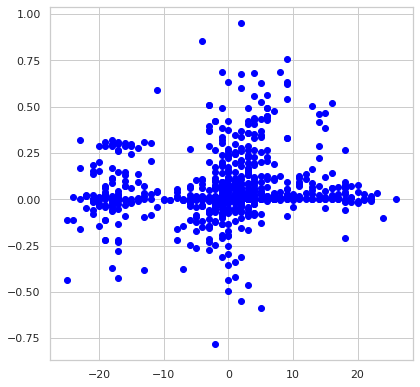

In [116]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
temp_df=merged_df.loc[merged_df.C6_Flag_diff1 != 0]
temp_df["change"]=temp_df.smoothed_cases_slope7-temp_df["smoothed_cases_slope-7"]
#plt.scatter(temp_df.AnyIntervention_diff1,temp_df.smoothed_cases_slope30,color="red")
#plt.scatter(temp_df.AnyIntervention_diff1,temp_df["smoothed_cases_slope-30"],color="blue")
plt.scatter(temp_df.AnyIntervention_diff1,temp_df["change"],color="blue")


array(['ABW0        0\n1        0\n2        0\n3        0\n4        0\n        ..\n89300    0\n89301    0\n89302    0\n89303    0\n89304    0\nName: RegionName, Length: 89305, dtype: object',
       'AFG0        0\n1        0\n2        0\n3        0\n4        0\n        ..\n89300    0\n89301    0\n89302    0\n89303    0\n89304    0\nName: RegionName, Length: 89305, dtype: object',
       'AGO0        0\n1        0\n2        0\n3        0\n4        0\n        ..\n89300    0\n89301    0\n89302    0\n89303    0\n89304    0\nName: RegionName, Length: 89305, dtype: object',
       'ALB0        0\n1        0\n2        0\n3        0\n4        0\n        ..\n89300    0\n89301    0\n89302    0\n89303    0\n89304    0\nName: RegionName, Length: 89305, dtype: object',
       'AND0        0\n1        0\n2        0\n3        0\n4        0\n        ..\n89300    0\n89301    0\n89302    0\n89303    0\n89304    0\nName: RegionName, Length: 89305, dtype: object',
       'ARE0        0\n1        0\n2    